In [96]:
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy import optimize
from sklearn.metrics import mean_squared_log_error, mean_squared_error

import math  
import numpy as np
import pandas as pd

# SIR model

In [2]:
# Total population, N without china
N = 6.4 *(10**9)
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = 0.6, 1/10

In [3]:
# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt


In [4]:
# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
# ret = odeint(deriv, y0, [i for i in range(1000)], args=(N, beta, gamma))
ret = odeint(deriv, y0, [i for i in range(1000)], args=(N, beta, gamma))

S, I, R = ret.T


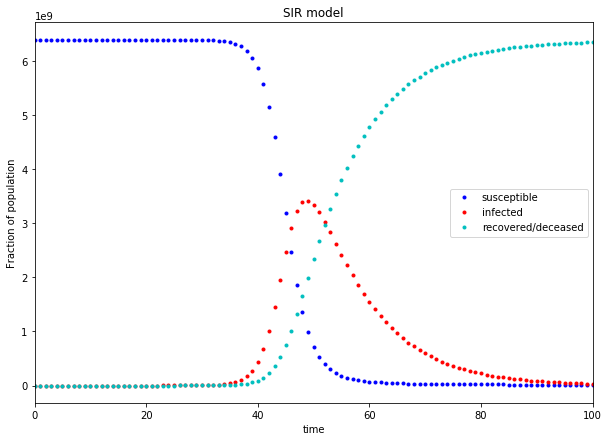

In [5]:
f = plt.figure(figsize=(10,7)) 
plt.plot(S, 'b.', label='susceptible');
plt.plot(I, 'r.', label='infected');
plt.plot(R, 'c.', label='recovered/deceased');
plt.title("SIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,100)
plt.show()

In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,22,24,24,40,40,74,84,94,110,110
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,64,70,76,89,104,123,146,174,186,197
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,87,90,139,201,230,264,302,367,409,454
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,53,75,88,113,133,164,188,224,267,308
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,0,1,2,2,3,3,3,4,4,5


In [7]:
df = df.groupby(['Country/Region']).sum().reset_index(level=['Country/Region'])


In [8]:
df.head()

,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20
0,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,...,22,24,24,40,40,74,84,94,110,110
1,Albania,41.1533,20.1683,0,0,0,0,0,0,0,...,64,70,76,89,104,123,146,174,186,197
2,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,...,87,90,139,201,230,264,302,367,409,454
3,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,...,53,75,88,113,133,164,188,224,267,308
4,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,...,0,1,2,2,3,3,3,4,4,5


In [9]:
dates = df.columns[4:]

df = df.melt(id_vars=[ 'Country/Region', 'Lat', 'Long'], 
                            value_vars=dates, var_name='Date', value_name='Confirmed')

In [10]:
df['Date'] =pd.to_datetime(df.Date)


In [11]:
df = df[df['Country/Region'] != 'China']
df_c = df
df.head()

,Country/Region,Lat,Long,Date,Confirmed
0,Afghanistan,33.0000,65.0000,2020-01-23,0
1,Albania,41.1533,20.1683,2020-01-23,0
2,Algeria,28.0339,1.6596,2020-01-23,0
3,Andorra,42.5063,1.5218,2020-01-23,0
4,Angola,-11.2027,17.8739,2020-01-23,0


In [12]:
df = df.groupby('Date')['Confirmed'].sum().reset_index()

In [13]:
df['Day num'] = np.arange(1, len(df)+1)
df.head()

,Date,Confirmed,Day num
0,2020-01-23,11,1
1,2020-01-24,21,2
2,2020-01-25,28,3
3,2020-01-26,43,4
4,2020-01-27,50,5


In [14]:
train = 0.85
index = math.ceil(train * len(df['Confirmed'].values))
index

57

In [15]:
Y = df['Confirmed'].values
X = x = df['Day num'].values

In [16]:
y = df['Confirmed'].values[:index]
x = df['Day num'].values[:index]

N = 6.4 *(10**9)
I0, R0 = y[0], 0
S0 = N - I0 - R0

In [17]:
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * y[0] * y[1] / N
    dIdt = beta * y[0] * y[1] / N - gamma * y[1]
    dRdt = gamma * y[1]
    return dSdt, dIdt, dRdt


In [18]:
def opt_ode(x, beta, gamma):
    return odeint(deriv, (S0, I0, R0), x, args=(N, beta, gamma))[:,1]



In [19]:
popt, pcov = optimize.curve_fit(opt_ode, x, y)

C:\Users\sahaav\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [20]:
# pcov

In [21]:
fitted = opt_ode(x, *popt)

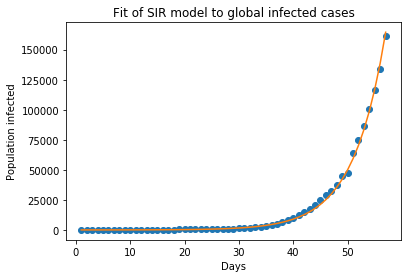

Optimal parameters: beta = 4.592003404732274  and gamma =  4.420020791106459


In [22]:
plt.plot(x, y, 'o')
plt.plot(x, fitted)
plt.title("Fit of SIR model to global infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

In [23]:
beta, gamma = popt[0], popt[1]

In [24]:
# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt


In [25]:
y0 = S0, I0, R0
ret = odeint(deriv, y0, [i for i in range(150)], args=(N, beta, gamma))

S, I, R = ret.T


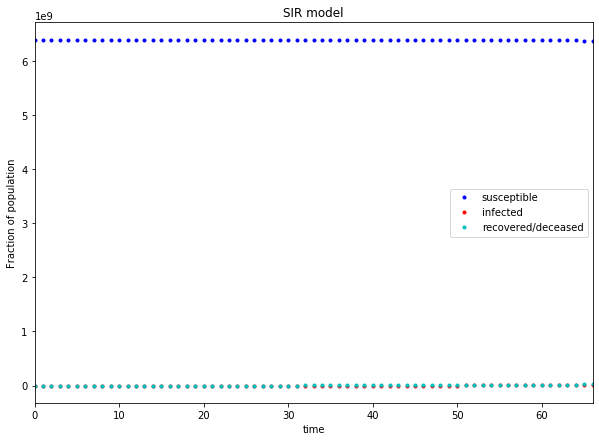

In [26]:
f = plt.figure(figsize=(10,7)) 
plt.plot(S, 'b.', label='susceptible');
plt.plot(I, 'r.', label='infected');
plt.plot(R, 'c.', label='recovered/deceased');
plt.title("SIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,len(X))
plt.show()

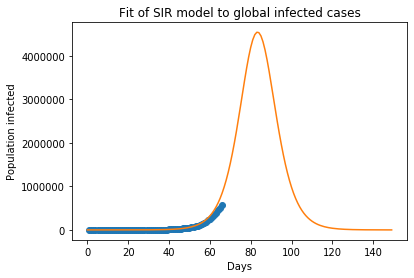

In [27]:
plt.plot(X, Y, 'o')
plt.plot([i for i in range(150)], I)
plt.title("Fit of SIR model to global infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()

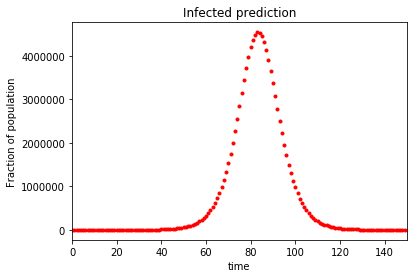

In [28]:
plt.plot(I, 'r.', label='infected');
plt.title("Infected prediction")
plt.xlabel("time");
plt.ylabel("Fraction of population");
plt.xlim(0,150)
plt.show()

In [29]:
max(I)

4541603.335450789

In [30]:
max(df['Confirmed'].values)

578707

# Analysing each country individualy

In [31]:
pop = pd.read_csv('datasets\population_by_country_2020.csv')
pop.head()

,Country (or dependency),Population (2020),Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (net),Fert. Rate,Med. Age,Urban Pop %,World Share
0,China,1439323776,0.39%,5540090,153,9388211,-348399.0,1.7,38,61%,18.47%
1,India,1380004385,0.99%,13586631,464,2973190,-532687.0,2.2,28,35%,17.70%
2,United States,331002651,0.59%,1937734,36,9147420,954806.0,1.8,38,83%,4.25%
3,Indonesia,273523615,1.07%,2898047,151,1811570,-98955.0,2.3,30,56%,3.51%
4,Pakistan,220892340,2.00%,4327022,287,770880,-233379.0,3.6,23,35%,2.83%


In [32]:
pop = pop[['Country (or dependency)', 'Population (2020)']].rename(columns = {'Country (or dependency)':'Country/Region',
                  'Population (2020)': 'Population'})

In [33]:
pop.head()

,Country/Region,Population
0,China,1439323776
1,India,1380004385
2,United States,331002651
3,Indonesia,273523615
4,Pakistan,220892340


In [34]:
df_c.head()

,Country/Region,Lat,Long,Date,Confirmed
0,Afghanistan,33.0000,65.0000,2020-01-23,0
1,Albania,41.1533,20.1683,2020-01-23,0
2,Algeria,28.0339,1.6596,2020-01-23,0
3,Andorra,42.5063,1.5218,2020-01-23,0
4,Angola,-11.2027,17.8739,2020-01-23,0


In [35]:
df_c = df_c.replace('US', 'United States').replace('Korea, South', 'South Korea')

In [36]:
countries = list(set(df_c['Country/Region'].values).intersection(set(pop['Country/Region'].values)))
# len(countries)

In [37]:
df_c[df_c['Country/Region'] == 'India']

,Country/Region,Lat,Long,Date,Confirmed
76,India,21.0,78.0,2020-01-23,0
253,India,21.0,78.0,2020-01-24,0
430,India,21.0,78.0,2020-01-25,0
607,India,21.0,78.0,2020-01-26,0
784,India,21.0,78.0,2020-01-27,0
...,...,...,...,...,...
10873,India,21.0,78.0,2020-03-24,536
11050,India,21.0,78.0,2020-03-25,657
11227,India,21.0,78.0,2020-03-26,727
11404,India,21.0,78.0,2020-03-27,887


In [38]:
N = int(pop[pop['Country/Region'] == 'India']['Population'])
N

1380004385

In [39]:
def deriv(y, t, beta, gamma):
    S, I, R = y
    dSdt = -beta * y[0] * y[1] / N
    dIdt = beta * y[0] * y[1] / N - gamma * y[1]
    dRdt = gamma * y[1]
    return dSdt, dIdt, dRdt

def opt_ode(x, beta, gamma):
    return odeint(deriv, (S0, I0, R0), x, args=(beta, gamma))[:,1]

def find_opt(df_opt):
    
    df_opt['Day num'] = np.arange(1, len(df_opt)+1)
    y = df_opt['Confirmed'].values
    x = df_opt['Day num'].values

#     N = pop
    I0, R0 = y[0], 0
    S0 = N - I0 - R0
    
    popt, pcov = optimize.curve_fit(opt_ode, x, y)    
    fitted = opt_ode(x, *popt)
    
    
    plt.plot(x, y, 'o')
    plt.plot(x, fitted)
    plt.title("Fit of SIR model to global infected cases")
    plt.ylabel("Population infected")
    plt.xlabel("Days")
    plt.show()
    print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

    
    return popt, fitted

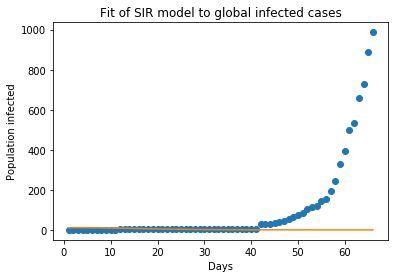

Optimal parameters: beta = 411.5608134792243  and gamma =  1908.6708699898481


In [40]:
temp = df_c[df_c['Country/Region'] == "India"].reset_index()
popt, fitted = find_opt(temp)

In [41]:
# temp
popt, fitted

(array([ 411.56081348, 1908.67086999]),
 array([11.        , 11.08560275, 11.10163327, 11.04768885, 10.92512214,
        10.73696957, 10.48779345, 10.1834515 ,  9.83081321,  9.43744618,
         9.01129514,  8.56037538,  8.09249776,  7.61503784,  7.13475617,
         6.65767215,  6.18898894,  5.73306431,  5.29342009,  4.87278194,
         4.47314118,  4.09583092,  3.74160953,  3.41074695,  3.10310823,
         2.81823232,  2.55540382,  2.31371659,  2.09212881,  1.88950968,
         1.70467807,  1.53643395,  1.38358321,  1.24495704,  1.1194261 ,
         1.00591092,  0.90338886,  0.81089835,  0.72754098,  0.65248193,
         0.58494909,  0.52423126,  0.46967565,  0.42068492,  0.37671399,
         0.33726661,  0.30189192,  0.27018108,  0.24176393,  0.21630585,
         0.19350469,  0.17308796,  0.15481013,  0.1384502 ,  0.12380937,
         0.11070898,  0.0989885 ,  0.08850385,  0.07912573,  0.07073814,
         0.06323712,  0.05652947,  0.05053167,  0.04516895,  0.04037431,
         0.

# SEIR model

In [42]:
# Total population, N without china
N = 6.4 *(10**9)
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0, E0 = 1, 0, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0 - E0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma, sigma = 0.6, 1/10, 0.1

In [43]:
# The SIR model differential equations.
def deriv(y, t, N, beta, gamma, sigma):
    S, E, I, R = y
    dSdt = (-beta * S * I) / N
    dEdt = ((beta * S * I) / N) - (sigma * E) 
    dIdt = (sigma * E) - (gamma * I)
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt


In [45]:
# Initial conditions vector
y0 = S0, E0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, [i for i in range(1000)], args=(N, beta, gamma, sigma))

S, E, I, R = ret.T


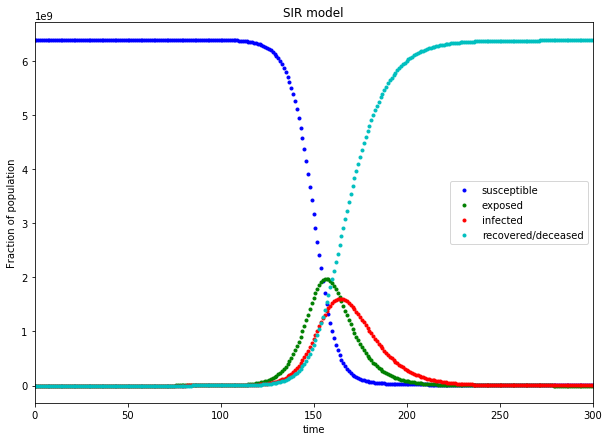

In [50]:
f = plt.figure(figsize=(10,7)) 
plt.plot(S, 'b.', label='susceptible');
plt.plot(E, 'g.', label='exposed');
plt.plot(I, 'r.', label='infected');
plt.plot(R, 'c.', label='recovered/deceased');
plt.title("SIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,300)
plt.show()

In [663]:
train = 0.8
index = math.ceil(train * len(df['Confirmed'].values))
index

53

In [637]:
Y = df['Confirmed'].values
X = x = df['Day num'].values

In [638]:
y = df['Confirmed'].values[:index]
x = df['Day num'].values[:index]

N = int(pop[pop['Country/Region'] != 'China']['Population'].sum())
I0, R0, E0 = y[0], 0, 0
S0 = N - I0 - R0 - E0

In [705]:
def deriv(y, t, N, beta, gamma, sigma):
    S, E, I, R = y
    dSdt = (-beta * S * I) / N
    dEdt = ((beta * S * I) / N) - (sigma * E) 
    dIdt = (sigma * E) - (gamma * I)
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt


In [706]:
def opt_ode(x, beta, gamma, sigma):
    return odeint(deriv, (S0, E0, I0, R0), x, args=(N, beta, gamma, sigma))[:,1].clip(0)

def err(params, x):
    beta, gamma, sigma = params
    ret = odeint(deriv, (S0, E0, I0, R0), x, args=(N, beta, gamma, sigma))
    S, E, I, R = ret.T
    I = I.clip(0)
    error = np.sqrt(mean_squared_log_error(y, I, [1/i for i in x][::-1]))
    return error
    

In [725]:
# np.array(x)

In [708]:
popt, pcov = optimize.curve_fit(opt_ode, x, y, bounds = [0, np.inf])

result = optimize.minimize(err, popt, args=(x), method='BFGS', options={'maxiter': 500})

beta_hat = result.x
print(result)


      fun: 0.1732024348287105
 hess_inv: array([[  83.23560151,   83.2846664 , -163.59288829],
       [  83.2846664 ,   83.33404429, -163.69260408],
       [-163.5928883 , -163.69260409,  321.56810277]])
      jac: array([ 0.36600917, -0.43451215, -0.03518205])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 842
      nit: 71
     njev: 166
   status: 2
  success: False
        x: array([-0.88165173, -0.95865136,  1.54575197])


In [709]:
# pcov

In [710]:
# fitted = opt_ode(x, *popt)
# fitted = opt_ode(x, *beta_hat)
y0 = S0, E0, I0, R0
ret = odeint(deriv, y0, X, args=(N, *beta_hat))
# ret = odeint(deriv, y0, X, args=(N, *popt))

S, E, I, R = ret.T


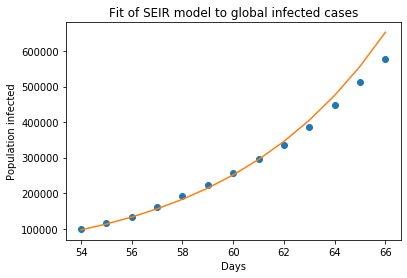

Optimal parameters: beta = 1.8042113573982936 , gamma =  0.7266296019996217 , sigma =  0.16124780607055073


In [711]:
plt.plot(X[index:], Y[index:], 'o')
plt.plot(X[index:], I[index:])
plt.title("Fit of SEIR model to global infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], ", gamma = ", popt[1],", sigma = ", popt[2] )

In [712]:
# beta, gamma, sigma = popt[0], popt[1], popt[2]
beta, gamma, sigma = beta_hat[0], beta_hat[1], beta_hat[2]

In [734]:
# The SIR model differential equations.
def deriv(y, t, N, beta, gamma, sigma):
    S, E, I, R = y
    dSdt = (-beta * S * I) / N
    dEdt = ((beta * S * I) / N) - (sigma * E) 
    dIdt = (sigma * E) - (gamma * I)
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt


In [735]:
y0 = S0, E0, I0, R0
ret = odeint(deriv, y0, [i for i in range(300)], args=(N, beta, gamma, sigma))

S, E, I, R = ret.T


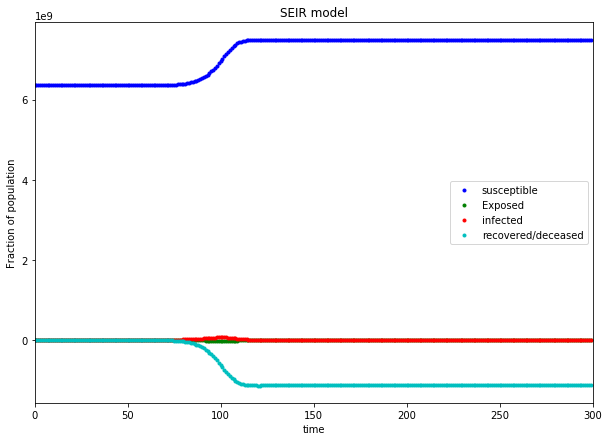

In [736]:
f = plt.figure(figsize=(10,7)) 
plt.plot(S, 'b.', label='susceptible');
plt.plot(E, 'g.', label='Exposed');
plt.plot(I, 'r.', label='infected');
plt.plot(R, 'c.', label='recovered/deceased');
plt.title("SEIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,300)
plt.show()

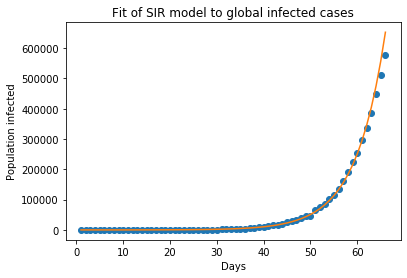

In [721]:
plt.plot(X, Y, 'o')
plt.plot(X, I)
plt.title("Fit of SIR model to global infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()

In [722]:
lim = len(y)
mse = mean_squared_error(y, I[:lim])
rmsle = (mean_squared_log_error(Y[index:], I[index:]))
print(rmsle)

0.0027062455057456133


In [653]:
# [1/i for i in x][::-1]

In [654]:
max(I)

665811.4133469954